**Loading and Preparing the Data**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import  precision_recall_curve

In [4]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

# Replace zeros in specified columns with the median of those columns
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in columns_to_impute:
    median_value = df[df[column] != 0][column].median()
    df[column] = df[column].replace(0, median_value)


In [5]:
# Splitting the data into features and target variable
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Data is ready; proceed to build the Random Forest model
X_train_scaled.shape, X_test_scaled.shape

((614, 8), (154, 8))

**Model Building**

In [7]:


# Create the Random Forest model with default parameters
random_forest_model = RandomForestClassifier(random_state=42)

# Train the model on the scaled training data
random_forest_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Predicting the testing set results
y_rf_pred = random_forest_model.predict(X_test_scaled)

**Classification report**

In [9]:
# Evaluating the model
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_conf_matrix = confusion_matrix(y_test, y_rf_pred)
rf_classification_report = classification_report(y_test, y_rf_pred)

rf_accuracy, rf_conf_matrix, rf_classification_report

(0.7337662337662337,
 array([[78, 21],
        [20, 35]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.80      0.79      0.79        99\n           1       0.62      0.64      0.63        55\n\n    accuracy                           0.73       154\n   macro avg       0.71      0.71      0.71       154\nweighted avg       0.73      0.73      0.73       154\n')

**Using GridCV for better performance**|

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [11]:
# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_rf.predict(X_test_scaled)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\Al-Hussain Com\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
254 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Al-Hussain Com\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Al-Hussain Com\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\Al-Hussain Com\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", l

**Classification report from the best model**

In [12]:
# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Model Parameters:", grid_search.best_params_)
print("Best Model Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Best Model Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Model Accuracy: 0.7597402597402597
Confusion Matrix:
 [[78 21]
 [16 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81        99
           1       0.65      0.71      0.68        55

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154



**Model's Performance**

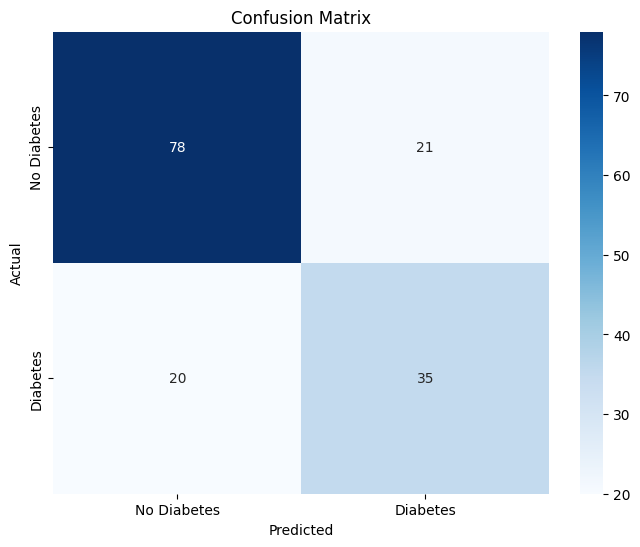

In [13]:


# Assuming y_test and y_pred are available from your model predictions
conf_mat = confusion_matrix(y_test, y_rf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


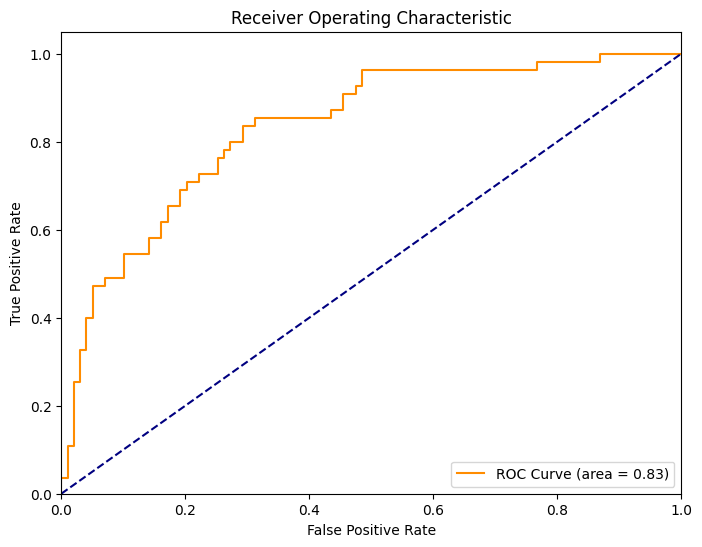

In [14]:

# Predict probabilities
y_probs = best_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [15]:

# Predict probabilities for the test set
probabilities = best_rf.predict_proba(X_test_scaled)[:, 1]

# Define thresholds
thresholds = np.linspace(0.1, 0.9, 9)

# Initialize lists to store the metrics
sensitivities = []
specificities = []

for threshold in thresholds:
    # Apply threshold
    y_pred_threshold = (probabilities >= threshold).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Store metrics
    sensitivities.append(sensitivity)
    specificities.append(specificity)

    print(f"Threshold: {threshold:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

Threshold: 0.10, Sensitivity: 0.96, Specificity: 0.33
Threshold: 0.20, Sensitivity: 0.96, Specificity: 0.51
Threshold: 0.30, Sensitivity: 0.85, Specificity: 0.66
Threshold: 0.40, Sensitivity: 0.78, Specificity: 0.73
Threshold: 0.50, Sensitivity: 0.71, Specificity: 0.79
Threshold: 0.60, Sensitivity: 0.60, Specificity: 0.84
Threshold: 0.70, Sensitivity: 0.45, Specificity: 0.95
Threshold: 0.80, Sensitivity: 0.22, Specificity: 0.98
Threshold: 0.90, Sensitivity: 0.07, Specificity: 0.99


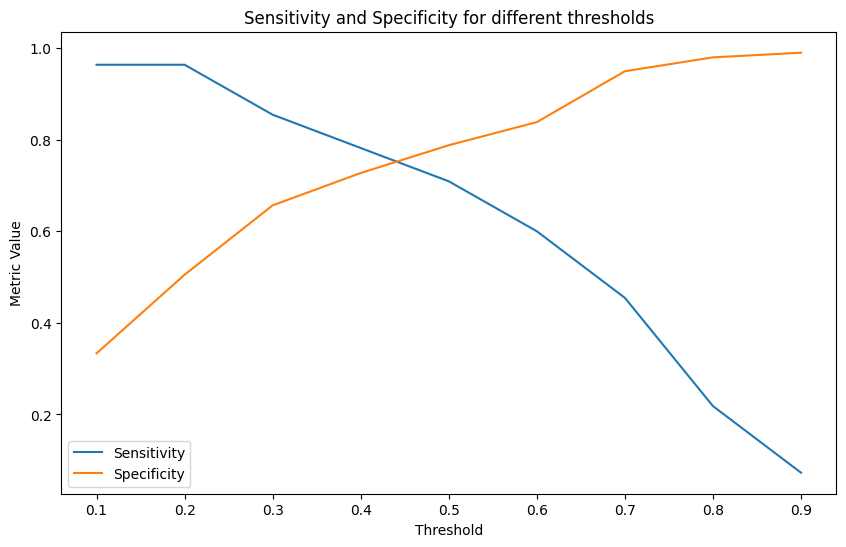

In [16]:
# Optional: Plot sensitivity and specificity for different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sensitivities, label='Sensitivity')
plt.plot(thresholds, specificities, label='Specificity')
plt.title('Sensitivity and Specificity for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [17]:
# Predict probabilities for the positive class (Diabetes)
probabilities = best_rf.predict_proba(X_test_scaled)[:, 1]


In [18]:
# Define the threshold
selected_threshold = 0.3

# Apply threshold to convert probabilities to binary outcomes
y_pred_adjusted = (probabilities >= selected_threshold).astype(int)


In [19]:
# Evaluate the adjusted predictions
new_accuracy = accuracy_score(y_test, y_pred_adjusted)
new_conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
new_classification_report = classification_report(y_test, y_pred_adjusted)

# Print out the new results
print("New Accuracy:", new_accuracy)
print("New Confusion Matrix:\n", new_conf_matrix)
print("New Classification Report:\n", new_classification_report)


New Accuracy: 0.7272727272727273
New Confusion Matrix:
 [[65 34]
 [ 8 47]]
New Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.66      0.76        99
           1       0.58      0.85      0.69        55

    accuracy                           0.73       154
   macro avg       0.74      0.76      0.72       154
weighted avg       0.78      0.73      0.73       154



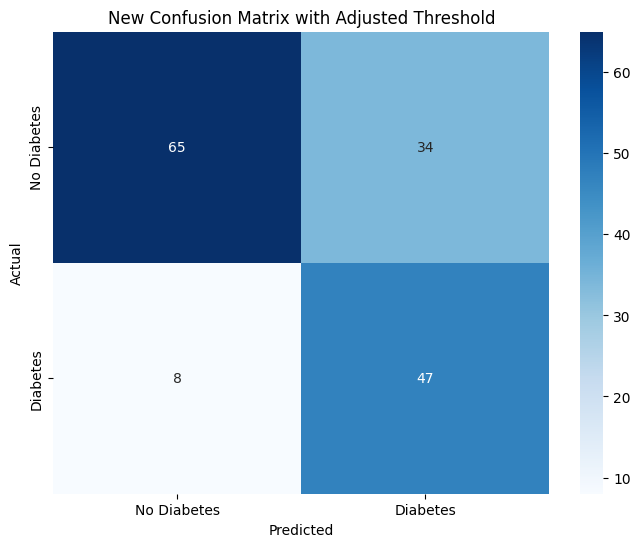

In [20]:


plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('New Confusion Matrix with Adjusted Threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [31]:
def predict_diabetes(best_rf, scaler, Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, threshold=0.3):
    import numpy as np

    features = np.array([[Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age]])
    
    features_scaled = scaler.transform(features)
    
    probability = best_rf.predict_proba(features_scaled)[0, 1]
    
    if probability >= threshold:
        return "Diabetic"
    else:
        return "Non-Diabetic"

result = predict_diabetes(best_rf, scaler, 2, 120, 70, 30, 85, 32.0, 0.627, 50)
print("The prediction is:", result)


The prediction is: Diabetic


C:\Users\Al-Hussain Com\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
